In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

**Funciones extraidas de** *Tarea1-ejemplo* desde canvas marcado como **#extraido**

In [13]:
#extraido
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [14]:
#extraido
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [22]:
#extraido
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return

In [15]:
#extraido
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

In [16]:
#extraido
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

Para la **distancia geodesica** haremos uso de un **Radio = 6371** correspondiente al de la Tierra

*Complete codigo usando Chatgpt para simplificar la formula literal:*  
         *Rarc cos (sen(φ1) sen(φ2) + cos(φ1) cos(φ2) cos(λ2 −λ1))*

In [17]:
def distance_geodesic(x, y, R=6371):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    R : float, optional
        Radius of the Earth in kilometers. Defaults to 6371 km.
    """
    # Convert degrees to radians
    lat1, lon1 = np.radians(x[0]), np.radians(x[1])
    lat2, lon2 = np.radians(y[0]), np.radians(y[1])
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Calculate intermediate values
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Calculate distance
    distance = R * c
    return distance

In [18]:
#extraido
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [19]:
n_neighbours = 5

Realizamos un cambio en el metodo de **distancia** a usar. Pasando a ser la distancia **geodesica**

In [20]:
#extraido, cambio de euclidean --> geodesic
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

Visualizamos los graficos empiricos y los de red global para ver facilitar su comprension

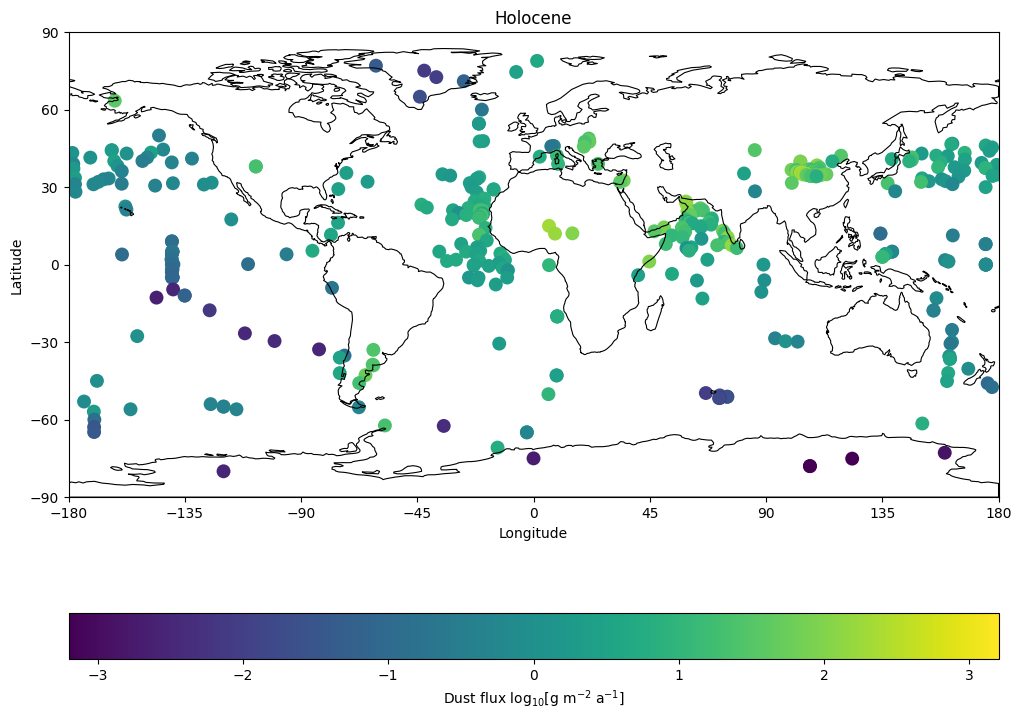

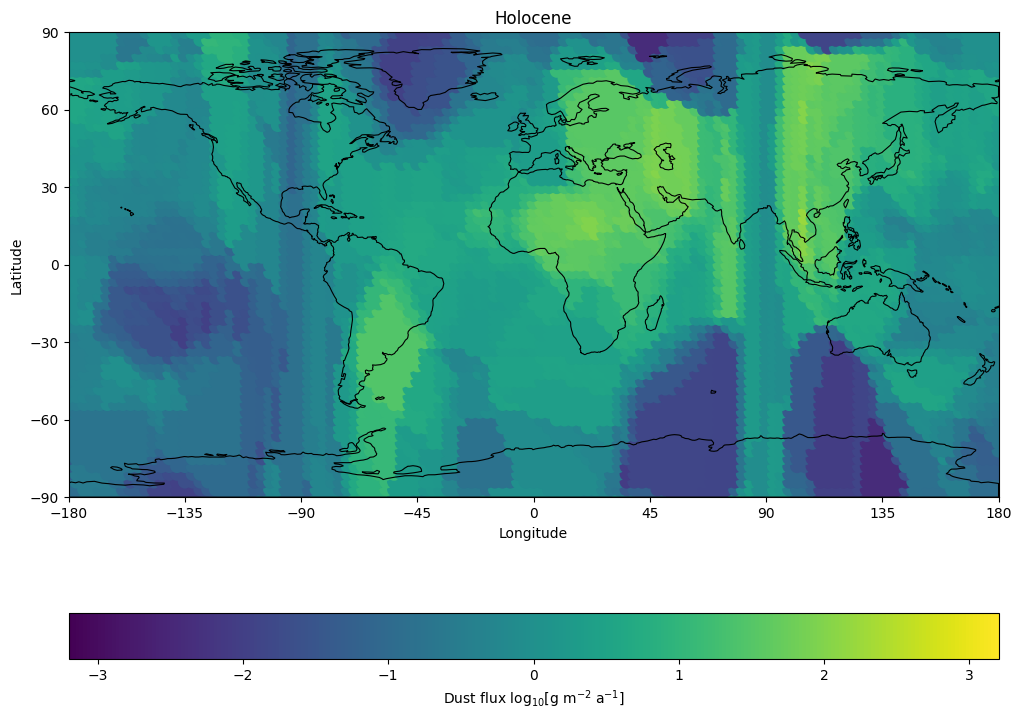

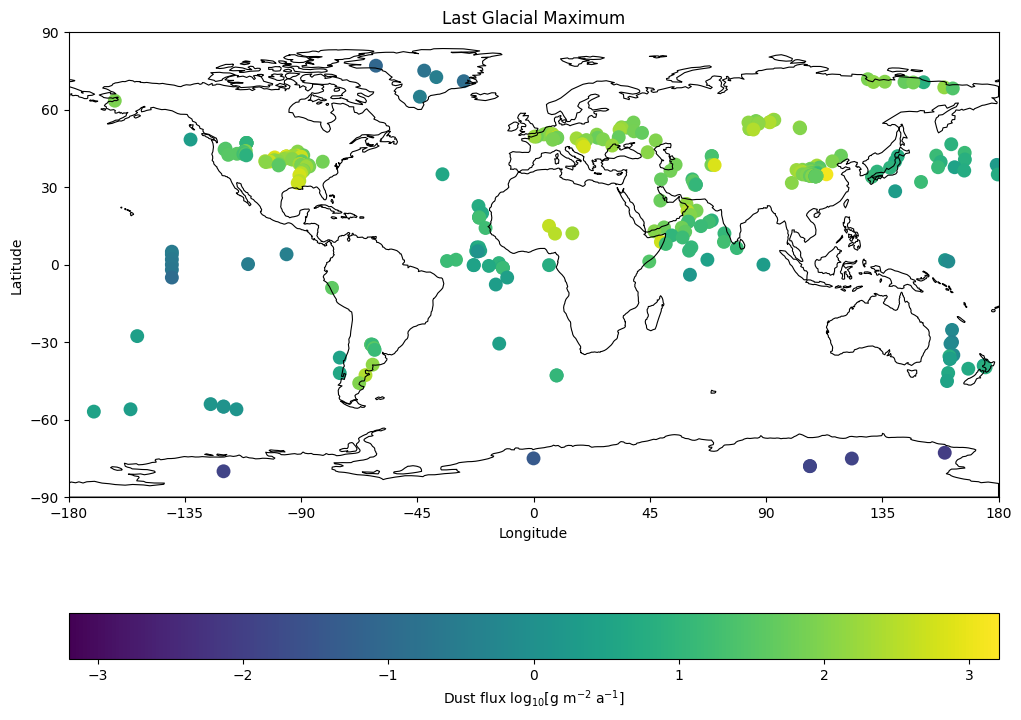

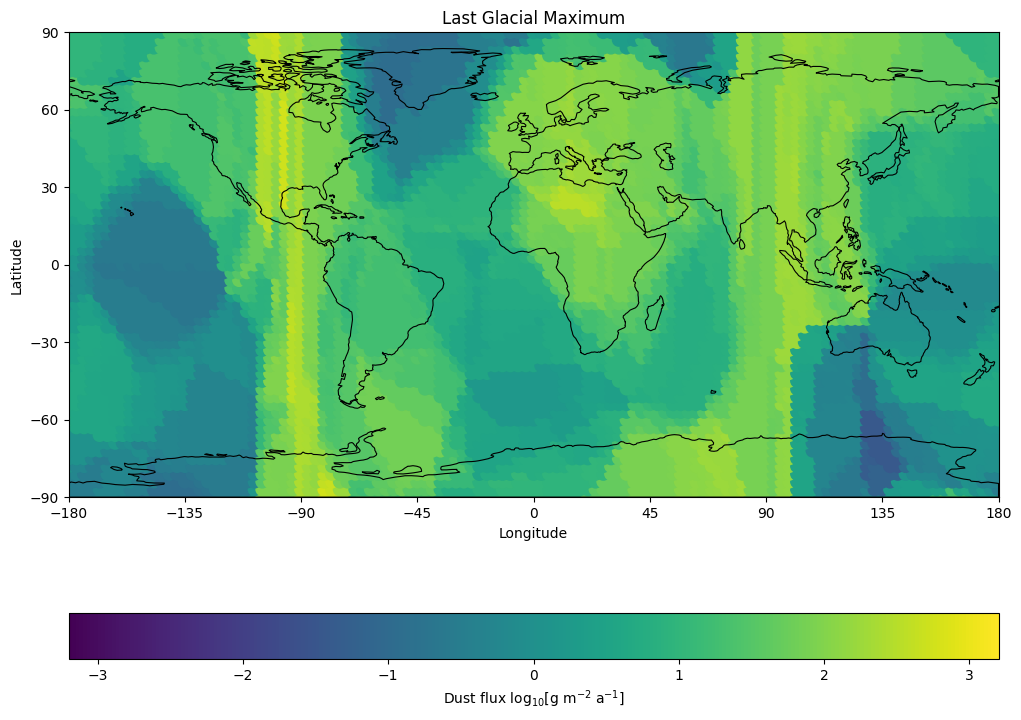

In [26]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')



Calculamos las **diferencias** entre ambas distancias y las observamos mediante la opacidad del color vista en el mapa donde:
0 --> mas claro, indica menor diferencia (cercano al 0)
0+ --> mas nitido, mayor diferencia

*Hago uso chatGPT para crear las listas nuevas de diferencia entre las estimaciones*

***Notar** que calculamos nuevamente las estimaciones para la distancia*
*geodesica y anadimos la euclidiana, por lo que es posible que demore un poco mas*
*que el calculo anterior*

In [25]:
# Lista para almacenar las estimaciones de deposición de polvo para el Holoceno utilizando la distancia geodésica y euclidiana
est_hol_geod = []
est_hol_euclidiana = []

# Calcular las estimaciones para cada punto en la cuadrícula global para el Holoceno
for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    
    # Calcular la estimación utilizando la distancia geodésica para el Holoceno
    est_geod = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    est_hol_geod.append(est_geod)
    
    # Calcular la estimación utilizando la distancia euclidiana para el Holoceno
    est_euclidiana = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    est_hol_euclidiana.append(est_euclidiana)

# Agregar las estimaciones al DataFrame df_global_grid para el Holoceno
df_global_grid["est_hol_geod"] = est_hol_geod
df_global_grid["est_hol_euclidiana"] = est_hol_euclidiana

# Calcular la diferencia entre las estimaciones para el Holoceno
diferencia_hol = df_global_grid["est_hol_geod"] - df_global_grid["est_hol_euclidiana"]

# Calcular las estimaciones de vecinos más cercanos con distancia geodésica y euclidiana para el LGM
n_neighbours = 5

# Lista para almacenar las estimaciones de deposición de polvo para el LGM utilizando la distancia geodésica y euclidiana
est_lgm_geod = []
est_lgm_euclidiana = []

# Calcular las estimaciones para cada punto en la cuadrícula global para el LGM
for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    
    # Calcular la estimación utilizando la distancia geodésica para el LGM
    est_geod = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')
    est_lgm_geod.append(est_geod)
    
    # Calcular la estimación utilizando la distancia euclidiana para el LGM
    est_euclidiana = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')
    est_lgm_euclidiana.append(est_euclidiana)

# Agregar las estimaciones al DataFrame df_global_grid para el LGM
df_global_grid["est_lgm_geod"] = est_lgm_geod
df_global_grid["est_lgm_euclidiana"] = est_lgm_euclidiana

# Calcular la diferencia entre las estimaciones para el LGM
diferencia_lgm = df_global_grid["est_lgm_geod"] - df_global_grid["est_lgm_euclidiana"]

***Plot de la visualizacion***

*Se hace uso de ChatGPT para corregir errores y componer la diferencia de un color unico*

<Figure size 2000x2400 with 0 Axes>

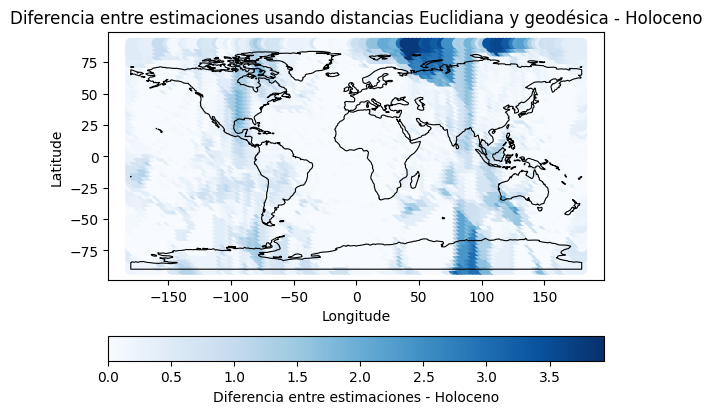

<Figure size 2000x2400 with 0 Axes>

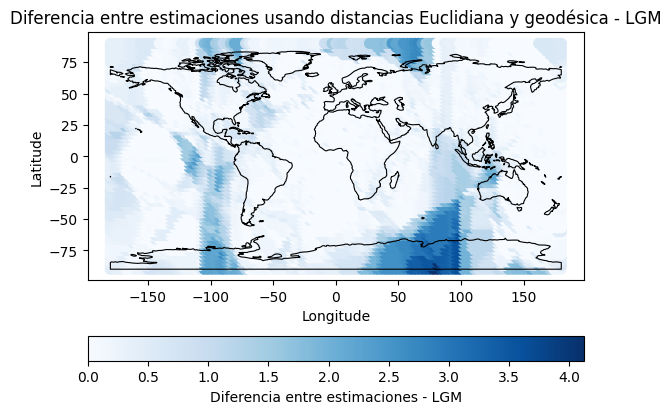

In [36]:
# Plot del mapa de calor para el Holoceno
plt.figure(figsize=(20, 24))
world_map.boundary.plot(color='black', linewidth=0.8)
plt.scatter(df_global_grid["lon"], df_global_grid["lat"], c=diferencia_hol.abs(), cmap='Blues', s=50, vmin=0, vmax=diferencia_hol.abs().max())  # Utilizar la escala de color Blues
cbar = plt.colorbar(label='Diferencia entre estimaciones - Holoceno', orientation='horizontal', pad=0.15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Diferencia entre estimaciones usando distancias Euclidiana y geodésica - Holoceno')
plt.show()

# Plot del mapa de calor para el LGM
plt.figure(figsize=(20, 24))
world_map.boundary.plot(color='black', linewidth=0.8)
plt.scatter(df_global_grid["lon"], df_global_grid["lat"], c=diferencia_lgm.abs(), cmap='Blues', s=50, vmin=0, vmax=diferencia_lgm.abs().max())  # Utilizar la escala de color Blues
cbar = plt.colorbar(label='Diferencia entre estimaciones - LGM', orientation='horizontal', pad=0.15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Diferencia entre estimaciones usando distancias Euclidiana y geodésica - LGM')
plt.show()

En base a las visualizaciones anteriores podemos observar diferencias significativas entre las estimaciones, se deduce que la distancia euclidiana (al ser una formula donde en este caso se esta usando en un plano 2D)
no tiene en cuenta la curvatura de la Tierra, lo que puede llevar a estimaciones inexactas, especialente en lugares donde hay "complejidades" topograficas, tales como montanas o cordilleras.

Por otro lado, la distancia geodesica si tiene en cuenta la curvatura de la Tierra, proporionando estimaciones mas precisas (se puede observar al hacer una comparacion visual con los graficos que contienen los puntos empiricos).

##### **a) ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?**
Tengamos en cuenta que la distancia euclidiana se calcula en un espacio plano, mientras que la distancia geodésica tiene en cuenta la curvatura de la Tierra.

Podemos deducir que las diferencias pueden ser mas grandes en ciertas partes del mundo donde la curva de la esfera se aleja, es decir, podemos notar que en las lineas creadas por los ceros (de esta forma " + ") hay menor diferencia, lo que puede significar que las "esquinas" tomadas por la distancia euclidiana es totalmente diferente a las "curvas" que toma la distancia geodesica 

##### **b) ¿Cuál método es más fidedigno en los polos sur y norte?**
En los polos sur y norte las lineas de longitud se juntan, creando cierta "distorsion" que la distancia euclidiana no considera. Es por ello, que es mas
fidedigno usar la distancia geodesica debido a que tiene en cuenta la curvatura de la Tierra.

##### **c) ¿Cuál método es más fidedigno en longitud 180°?**
En la longitud 180°, como mencionamos anteriormente, existe tambien cierta distorsion ya que el plano se "junta con el otro extremo".
Es por ello que considerariamos mas fidedigna la distancia geodesica ya que nuevamente tiene en cuenta la curvatura de la Tierra.

##### **d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?**
Las diferencias entre los resultados se pueden ver mas notoriamente en los polos, donde podemos deducir que es por el hecho de que la distancia
euclidiana no tiene una estimacion muy exacta donde se halla una curvatura mas "alejada".

##### **e) ¿Cómo elegir el número de vecinos cercanos?**
Para seleccionar el numero adecuado de vecinos cercanos es importante encontrar un equilibrio entre tener suficientes vecinos para capturar la variabilidad con precisión, pero, tampoco tener demasiados ya que puede conducir a una complejidad computacional mas grande.